## MPNN

In [9]:
"""
Property prediction using a Message-Passing Neural Network.
"""
import subprocess
import argparse
import logging

import dgl
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

from dgllife.model.model_zoo import MPNNPredictor
from dgllife.utils import CanonicalAtomFeaturizer, CanonicalBondFeaturizer, smiles_to_bigraph

from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100

from IPython import display
%matplotlib inline

In [7]:
from utils import Optimizer, UgiLoaderFast

In [18]:
if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'


def mpnn(args, df_rf):
    
    df = pd.read_csv(args.path)
#     print(df)
    
    y_train = pd.read_csv(args.path)['dock_score'].to_numpy()
    len_df = len(pd.read_csv(args.path))

    y_scaler = StandardScaler()

    # Initialise featurisers
    atom_featurizer = CanonicalAtomFeaturizer()
    bond_featurizer = CanonicalBondFeaturizer()

    e_feats = bond_featurizer.feat_size('e')
    n_feats = atom_featurizer.feat_size('h')
    print('Number of node features: ', n_feats)
    print('Number of edge features: ', e_feats)
    
    r2_list = []
    rmse_list = []
    skipped_trials = 0

    for i in range(args.n_trials):
        writer = SummaryWriter('runs/'+args.save_name)

        if args.test:
            train_ind, test_ind, y_train, _  = train_test_split(range(len_df), y_train, test_size=args.test_set_size, random_state=i+5)
        else:
            train_ind = range(len_df)

        y_scaler = y_scaler.fit(y_train.reshape(-1,1))

        train_loader = UgiLoaderFast(args.path, inds=train_ind, batch_size=args.batch_size, shuffle=True, y_scaler=y_scaler)
        if args.test:
            test_loader = UgiLoaderFast(args.path, inds=test_ind, batch_size=args.batch_size, shuffle=False, y_scaler=y_scaler)

        if args.val_path is not None:
            val_ind = range(len(pd.read_csv(args.val_path)))
            val_loader = UgiLoaderFast(args.val_path, inds=val_ind, batch_size=args.batch_size, shuffle=False, y_scaler=y_scaler)

        mpnn_net = MPNNPredictor(node_in_feats=n_feats,
                     edge_in_feats=e_feats,
                     node_out_feats=32,
                     edge_hidden_feats=32,
                     num_step_message_passing=4,
                     num_step_set2set=2,
                     num_layer_set2set=3)
    
        loss_fn = MSELoss()
        optimizer = Optimizer(model = mpnn_net,
                              optimizer = torch.optim.Adam(mpnn_net.parameters(), lr=args.lr),
                              lr = args.lr,
                              num_accum_times = 1)
        
        start_epoch=1
        start_batch=0
        
        mpnn_net = mpnn_net.to(device)
        print('Number of parameters: {}'.format(sum(p.numel() for p in mpnn_net.parameters() if p.requires_grad)))


        print('beginning training... trial #{}'.format(i))
        
        enumerator = rdMolStandardize.TautomerEnumerator()
        
        epoch_losses = []
        epoch_rmses = []
        for epoch in range(start_epoch, args.n_epochs+1):
            mpnn_net.train()
            epoch_loss = 0
            preds = np.array([None] * len(train_ind)).reshape(-1,1)
            labs = np.array([None] * len(train_ind)).reshape(-1,1)
            n = 0
            for i, (smiles, labels) in enumerate(train_loader, start=start_batch):
                loss = 0
                batch_preds = []
                labels = torch.tensor(labels, dtype=torch.float32).to(device)
                for j, smi in tqdm(enumerate(smiles), total=len(smiles)):
                    mol = Chem.MolFromSmiles(smi)
                    taut_smiles = [Chem.MolToSmiles(x) for x in enumerator.Enumerate(mol)]
                    
                    # batch tautomer graphs together
                    bg = [smiles_to_bigraph(taut_smi, node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer) for taut_smi in taut_smiles] 
                    bg = dgl.batch(bg).to(device)
                    bg.set_n_initializer(dgl.init.zero_initializer)
                    bg.set_e_initializer(dgl.init.zero_initializer)

                    atom_feats = bg.ndata.pop('h').to(device)
                    bond_feats = bg.edata.pop('e').to(device)
                    atom_feats, bond_feats = atom_feats.to(device), bond_feats.to(device)
                    
                    node_feats = mpnn_net.gnn(bg, atom_feats, bond_feats)
                    graph_feats = mpnn_net.readout(bg, node_feats)
#                     print('number of tautomers: {}'.format(len(taut_smiles)))
#                     print('Shape of graph feats: {}'.format(graph_feats.shape))
                    graph_feats = torch.mean(graph_feats, dim=0)
#                     print('Shape of graph feats after averaging: {}'.format(graph_feats.shape))
                    y_pred = mpnn_net.predict(graph_feats)
                    batch_preds.append(y_scaler.inverse_transform(y_pred.cpu().detach().numpy()))
        
                    # add loss from each individual mol
                    loss += loss_fn(y_pred, labels[j])

                # backprop loss after collecting losses from batch
                optimizer.backward_and_step(loss)
                epoch_loss += loss.detach().item()

                batch_preds = np.array(batch_preds)
                batch_labs = y_scaler.inverse_transform(labels.cpu().detach().numpy())

                x = batch_preds.flatten()
                y = batch_labs.flatten()
                
                preds[n: n + len(smiles) ] = batch_preds
                labs[n: n + len(smiles) ] = batch_labs.reshape(len(batch_labs),1)
                n += len(smiles)

            p = spearmanr(preds, labs)[0]
            rmse = np.sqrt(mean_squared_error(preds, labs))
            r2 = r2_score(preds, labs)

            print(f"\rRMSE: {rmse:.3e}, "
                  f"RHO: {p:.3e}, "
                  f"R2: {r2:.3e}, "
                  f"epoch: {epoch}", end='\x1b[2K\r')
            
            if epoch==1 or epoch%10==0:
                df_mpnn = pd.DataFrame(
                                { 'dock_score': labs.flatten().astype(float),
                                  'preds': preds.flatten().astype(float),
                                  'model': 'MPNN'    
                                }, index=df_rf.index)

                df_plot = pd.concat([df_rf, df_mpnn])
                plot = sns.jointplot(data=df_plot, x='dock_score', y='preds', kind='scatter', hue='model')
                dot_line = [np.amin(df['dock_score']), np.amax(df['dock_score'])]
                plot.ax_joint.plot(dot_line, dot_line, 'k:')
                plt.xlabel('Dock Scores')
                plt.ylabel('Predictions')
                plt.title('Epoch {}'.format(epoch))
                display.clear_output(wait=True)
                display.display(plt.gcf())
            if epoch%5==0:
                optimizer.decay_lr(0.8)
    return preds, labs

use CPU


In [23]:
DIR='/rds-d2/user/wjm41/hpc-work/datasets/Ugis'
model_dir = '/rds-d2/user/wjm41/hpc-work/models'

parser = argparse.ArgumentParser()

parser.add_argument('-p', '--path', type=str, default='ugis-00000000.csv',
                    help='Path to the data.csv file.')
parser.add_argument('-n_trials', '--n_trials', type=int, default=1,
                    help='int specifying number of random train/test splits to use')
parser.add_argument('-batch_size', '--batch_size', type=int, default=128,
                    help='int specifying batch_size for training and evaluations')
parser.add_argument('-write_batch', '--write_batch', type=int, default=1000,
                    help='int specifying number of steps per tensorboard write')
parser.add_argument('-save_batch', '--save_batch', type=int, default=500,
                    help='int specifying number of batches per model save')
parser.add_argument('-n_epochs', '--n_epochs', type=int, default=1000,
                    help='int specifying number of random train/test splits to use')
parser.add_argument('-ts', '--test_set_size', type=float, default=0,
                    help='float in range [0, 1] specifying fraction of dataset to use as test set')
parser.add_argument('-lr', '--lr', type=float, default=1e-3,
                    help='float specifying learning rate used during training.')
parser.add_argument('-test', action='store_true',
                    help='whether or not to do test/train split')
parser.add_argument('-val_path', default=None,
                    help='if not None, logs validation loss')
parser.add_argument('-debug', action='store_true',
                    help='whether or not to print predictions and model weight gradients')
parser.add_argument('-save_name', '--save_name', type=str, default='ugi-pretrained',
                    help='name for directory containing saved model params and tensorboard logs')
parser.add_argument('-load_name', '--load_name', default=None,
                    help='name for directory containing saved model params and tensorboard logs')

args = parser.parse_args(args=['--path', DIR+'/vsmall_test.csv',
                              '--load_name', model_dir+'/vsmall/model_epoch798.ckpt' ])

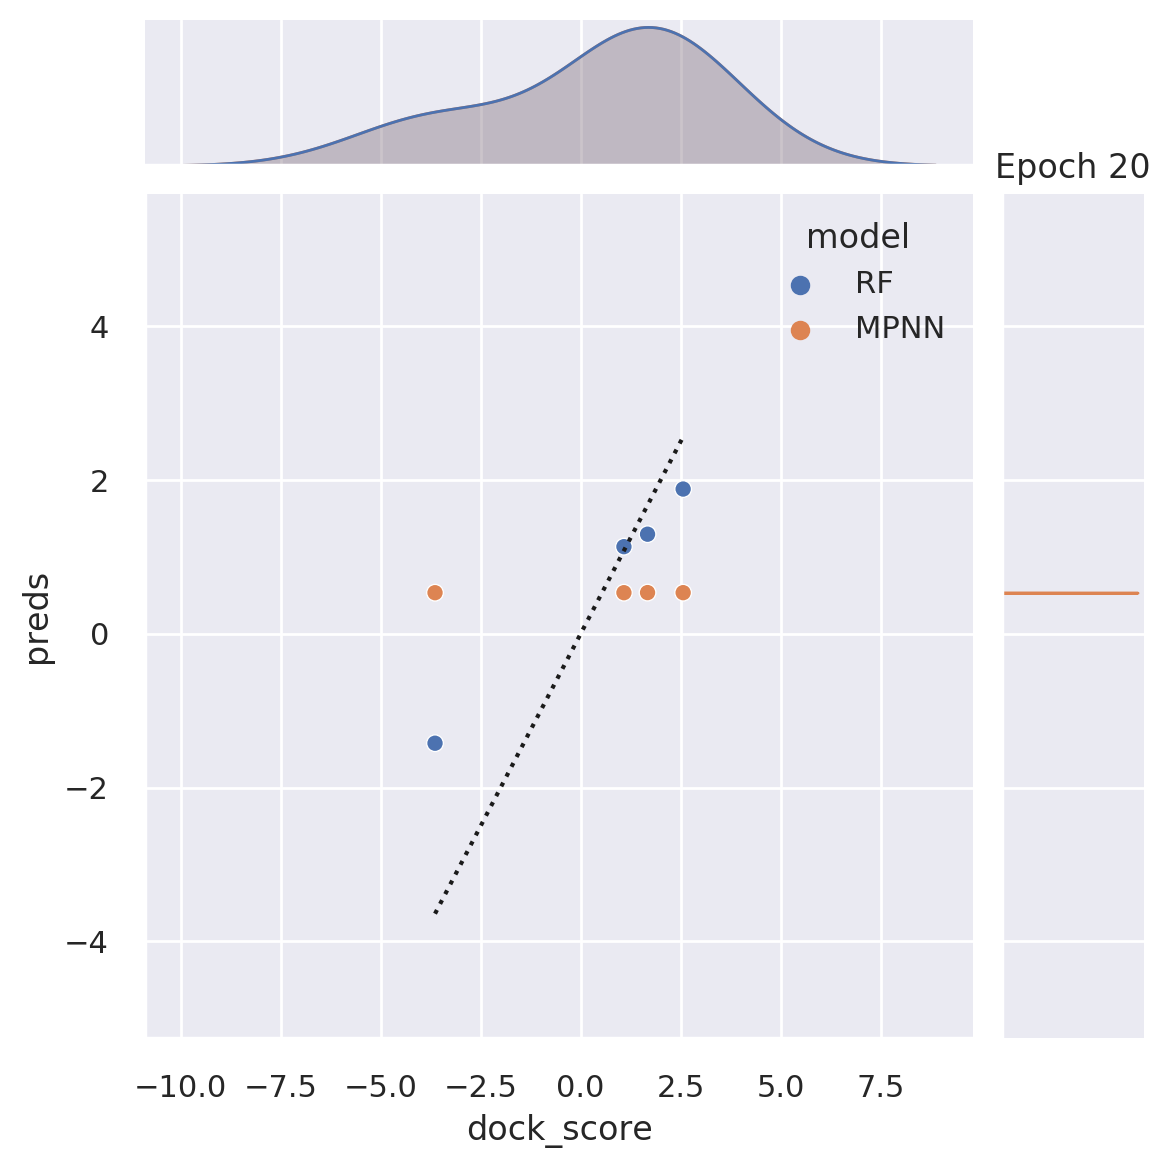

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]


KeyboardInterrupt: 

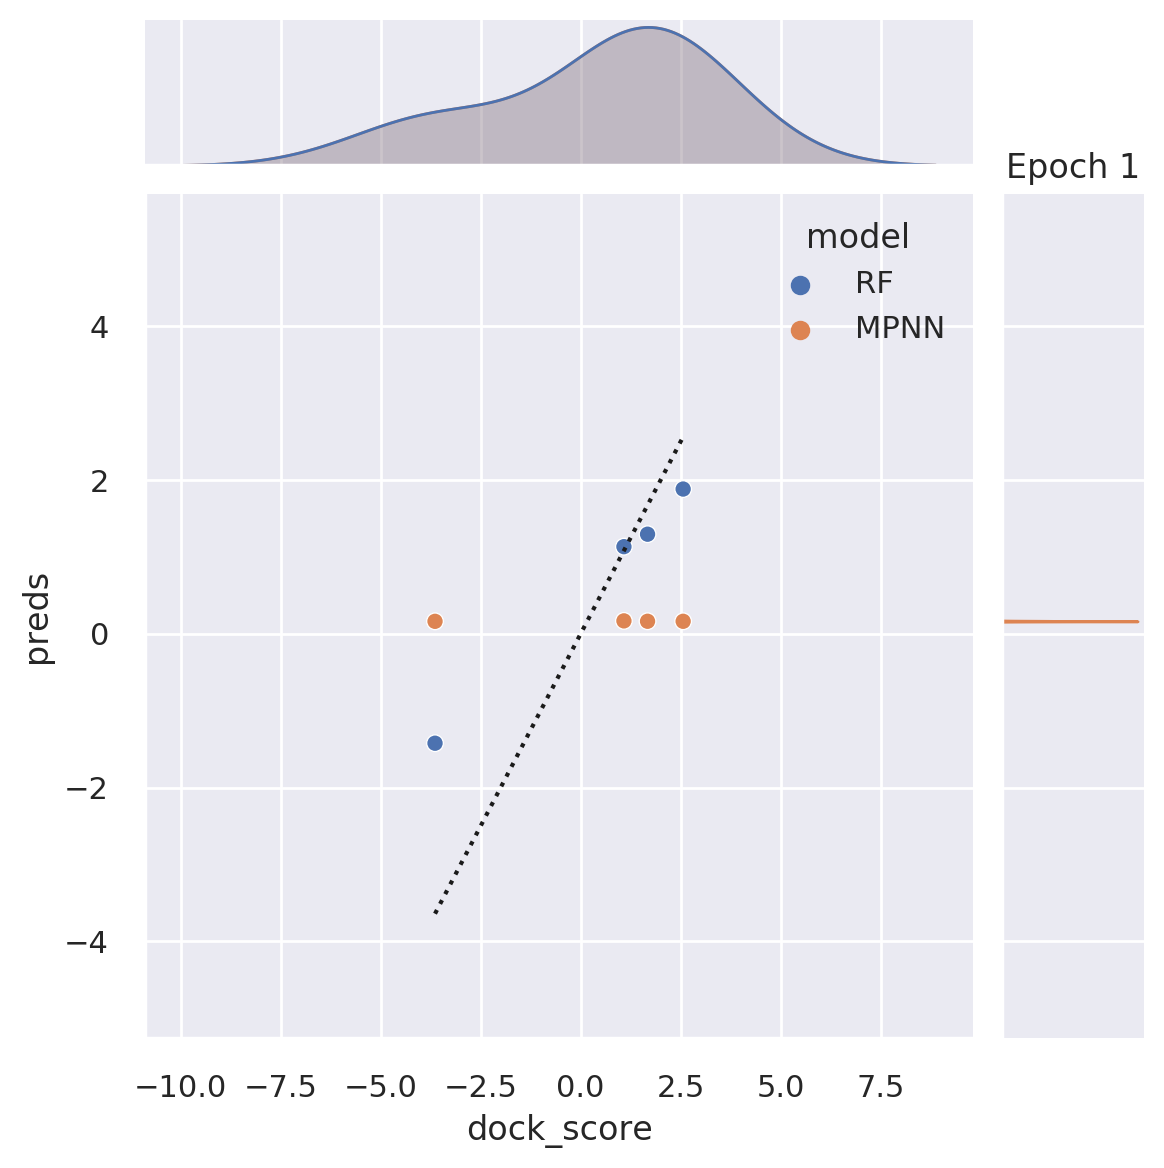

In [ ]:
plt.style.use('seaborn')
sns.set(rc={"figure.dpi":200})
# plt.plot(labs, preds, 'b.')

# plot = sns.jointplot(x=df['dock_score'], y=df['preds'], kind='scatter')


def generate_fingerprints(smile):
    mol = Chem.MolFromSmiles(smile)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=1024)
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, array)
    return array

df = pd.read_csv('vsmall_test.csv')
print('{} ugi mols'.format(len(df)))
X = [generate_fingerprints(smi) for smi in df['smiles'].values]
y = df['dock_score'].to_numpy()
model = RandomForestRegressor().fit(X, y)
y_pred = model.predict(X)

p = spearmanr(y_pred, y)[0]
rmse = np.sqrt(mean_squared_error(y_pred, y))
r2 = r2_score(y_pred, y)

print(f"RF RMSE: {rmse:.3g}, "
      f"RHO: {p:.3g}, "
      f"R2: {r2:.3g}")

df['preds'] = y_pred
df['model'] = 'RF'
df = df[['dock_score', 'preds', 'model']]
args = parser.parse_args(args=['--path', DIR+'/vsmall_test.csv',
                               '-n_epochs', '300',
                               '-batch_size', '4',
                               '-lr', '1e-1'])

preds, labs = mpnn(args, df)


In [ ]:
df = pd.DataFrame({'data': range(10)})
# print(df)
print(df.iloc[0:400])

In [ ]:
atom_featurizer = CanonicalAtomFeaturizer()
bond_featurizer = CanonicalBondFeaturizer()

e_feats = bond_featurizer.feat_size('e')
n_feats = atom_featurizer.feat_size('h')

mpnn_net = MPNNPredictor(node_in_feats=74,
             edge_in_feats=13,
             node_out_feats=32,
             edge_hidden_feats=32,
             num_step_message_passing=4,
             num_step_set2set=2,
             num_layer_set2set=3)

print(mpnn_net.predict)





In [6]:
df_old = pd.DataFrame(data={'dock_score': labs.flatten(), 'preds': old_preds.flatten()})
df_new = pd.DataFrame(data={'dock_score': labs.flatten(), 'preds': new_preds.flatten()})
df_all = pd.DataFrame(data={'dock_score': labs.flatten(), 'preds': all_preds.flatten()})
df_split = pd.DataFrame(data={'dock_score': labs.flatten(), 'preds': split_preds.flatten()})

df_old['df'] = 'old'
df_new['df'] = 'new'
df_all['df'] = 'all'
df_split['df'] = 'split'

df = pd.concat([df_old, df_new, df_all, df_split])

In [15]:
df = df[df['dock_score']<5]
df['dock_score'] = df['dock_score'].astype(float)
df['preds'] = df['preds'].astype(float)

df_new = df_new[df_new['dock_score']<5]
p = spearmanr(df_new['preds'], df_new['dock_score'])[0]
rmse = np.sqrt(mean_squared_error(df_new['preds'], df_new['dock_score']))
r2 = r2_score(df_new['preds'], df_new['dock_score'])

print(f"RMSE: {rmse:.3f}, "
      f"RHO: {p:.3f}, "
      f"R2: {r2:.3f}")

RMSE: 1.254, RHO: 0.689, R2: 0.214


In [12]:
print(df.preds.astype(float))

0       2.176505
1      -0.841290
2       1.629701
3       1.151530
4      -0.086982
          ...   
9411    0.420343
9412    3.885967
9413    5.282387
9414   -0.185993
9415    1.976164
Name: preds, Length: 37664, dtype: float64


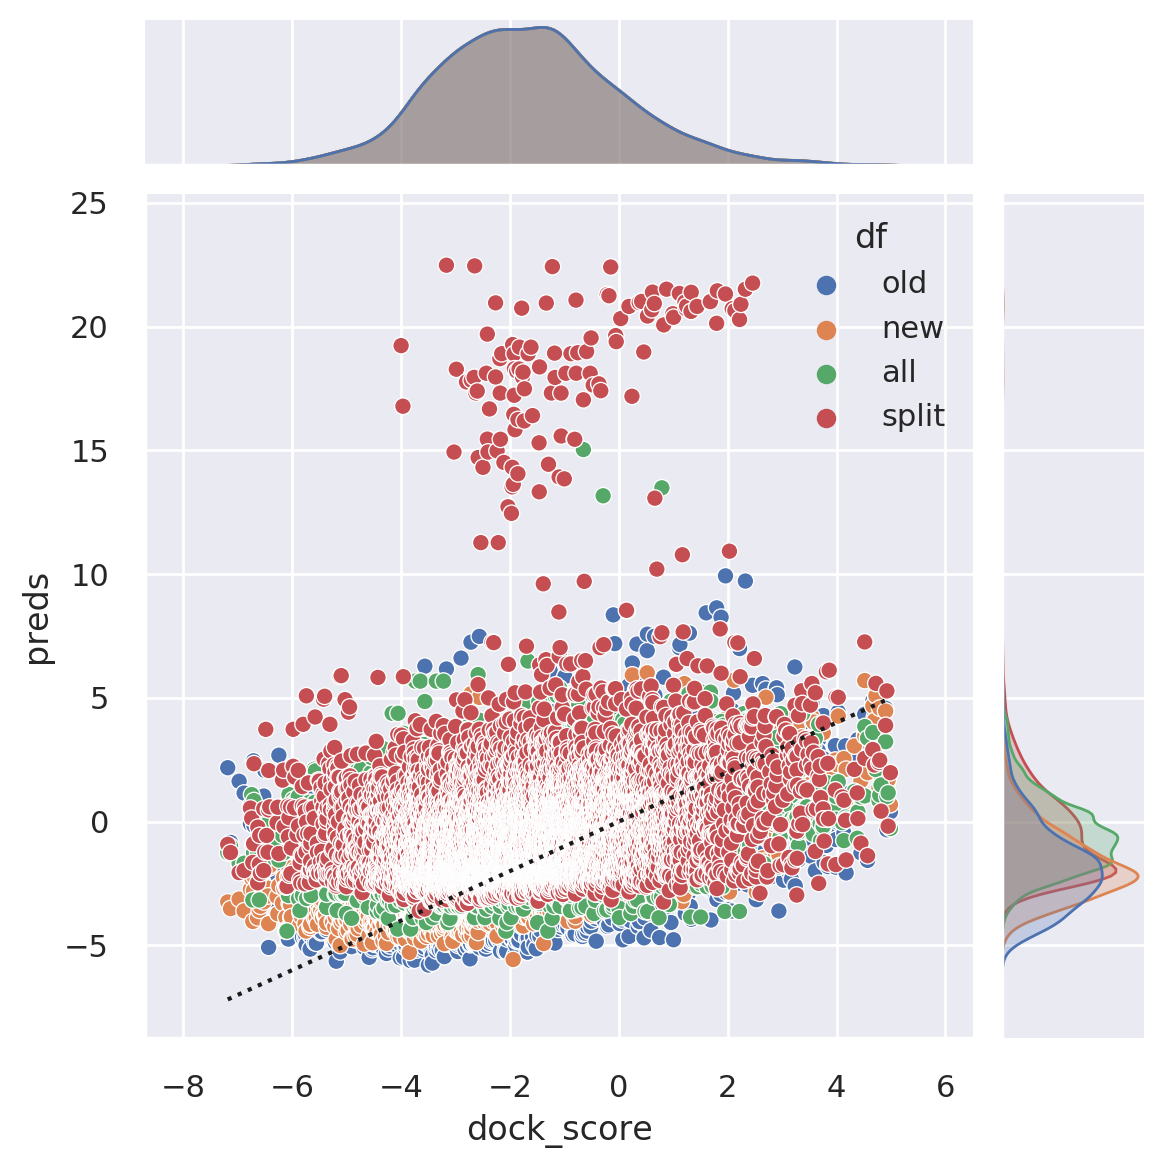

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
%matplotlib inline

import pandas as pd

plt.style.use('seaborn')
sns.set(rc={"figure.dpi":200})
# plt.plot(labs, preds, 'b.')

# plot = sns.jointplot(x=df['dock_score'], y=df['preds'], kind='scatter')
plot = sns.jointplot(data=df, x='dock_score', y='preds', hue='df', kind='scatter')
dot_line = [np.amin(df['dock_score']), np.amax(df['dock_score'])]
plot.ax_joint.plot(dot_line, dot_line, 'k:')
plt.xlabel('Dock Scores')
plt.ylabel('Predictions')
plt.show()